In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create inspector
inspector = inspect(engine)

In [9]:
# Inspect columns for Measurement
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Inspect columns for Station
columns = inspector.get_columns('Station')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date)[-1]
most_recent_date[0]

'2017-08-23'

In [13]:
# Convert most_recent_date to be used for datatime
year = int(most_recent_date[0][:4])
month = int(most_recent_date[0][5:7])
day = int(most_recent_date[0][8:])

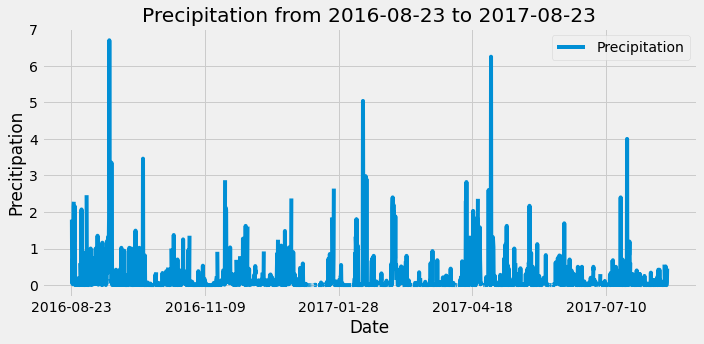

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.date(year, month, day)
# Calculate the date one year from the last date in data set.
query_date_1year = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date_1year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns=['Date','Precipitation']).set_index('Date')

# Sort the dataframe by date
prcp_df_sort = prcp_df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df_sort.plot(grid = True, ylabel= "Precitipation", title= f"Precipitation from {query_date_1year} to {most_recent_date[0]}", figsize = (10,5))
plt.tight_layout()
plt.savefig(f"../Images/Precipitation from {query_date_1year} to {most_recent_date[0]}.png")

plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_statistics = prcp_df_sort.describe()
summary_statistics

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
total_station = session.query(Station).group_by(Station.station).count()
print(f"Total stations in the dataset: {total_station}")

Total stations in the dataset: 9


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stations = active_stations[0][0]
prcp_most_active_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_stations).all()

print(f"Precipiation Statistics from the most active Station in Hawaii:\n\nLowest:\t {prcp_most_active_stats[0][0]}\n\
Max: \t {prcp_most_active_stats[0][1]}\nAverage: {round(prcp_most_active_stats[0][2],2)}")

Precipiation Statistics from the most active Station in Hawaii:

Lowest:	 54.0
Max: 	 85.0
Average: 71.66


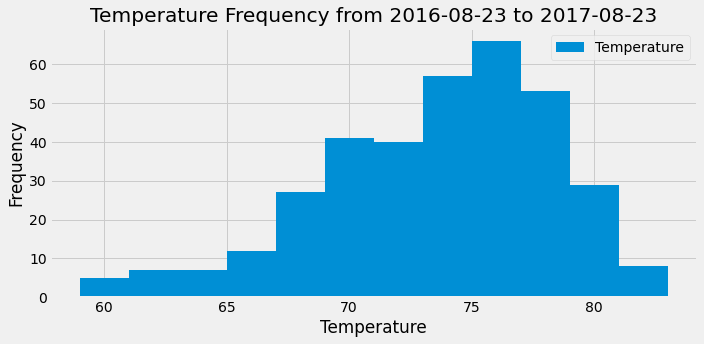

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
tmp_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= query_date_1year).\
    filter(Measurement.station == most_active_stations).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
tmp_df = pd.DataFrame(tmp_data, columns=['Date','Temperature']).set_index('Date')

# Plot the DataFrame as a histogram
tmp_df.plot(kind='hist', bins = 12, title = f"Temperature Frequency from {query_date_1year} to {most_recent_date[0]}", figsize = (10,5))
plt.xlabel('Temperature')
plt.tight_layout()
plt.savefig(f"../Images/Temperature Frequency from {query_date_1year} to {most_recent_date[0]}.png")

plt.show()

# Close session

In [20]:
# Close Session
session.close()